In [1]:
import caffe
import numpy as np
import os,sys,re
from pyquaternion import Quaternion as qt

#these might change - are also assuming the first channel is aliphatic carbon
LIGCHANNELS = 19
RECCHANNELS = 16


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
coords = np.array([[1.061, 0.053, 0.063],[2.573, 0.053, 0.063]])

def setmol(coords,fname='CC.xyz'):
    moltemplate='''2

C          %f        %f        %f
C          %f        %f        %f
'''
    xyz = open(fname,'w')
    xyz.write(moltemplate%tuple(coords.flatten()))
    xyz.close()
    
setmol(coords)

In [4]:
setmol(coords)
net = caffe.Net('plainpeturb.model',caffe.TEST)
res = net.forward()
peturb = res['peturb'][0].copy() #need to copy because returned values are references to blobs
data = res['data'][0].copy()

res = net.forward()
peturb2 = res['peturb'][0].copy()
data2 = res['data'][0].copy()

if len(peturb) != 10:
    print("Wrong number of rotational numbers")
    


In [5]:
center = coords.mean(axis=0)
center

array([1.817, 0.053, 0.063])

In [6]:
q = qt(peturb[3:7])
q.inverse.rotate((coords - center)[0])+center

array([ 1.61221903, -0.38277371, -0.51983963])

In [7]:
trans = peturb[:3]
q = qt(peturb[3:7])
newcoords = np.array(map(q.inverse.rotate,coords-center))+center-trans

setmol(newcoords)
plainnet = caffe.Net('plain.model',caffe.TEST)
plainres = plainnet.forward()
plaindata = plainres['data'][0].copy()


In [8]:
q,trans

(Quaternion(0.7770933508872986, 0.17766030132770538, 0.551988959312439, -0.24468572437763214),
 array([ 2.5978243,  3.7747965, -1.7708074], dtype=float32))

In [9]:
newcoords.mean(axis=0)

array([-0.78082434, -3.72179649,  1.83380739])

In [10]:
np.square(plaindata - data).sum()

2.0209764e-11

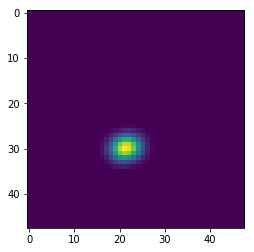

In [11]:
plt.imshow(data[0].sum(axis=0))

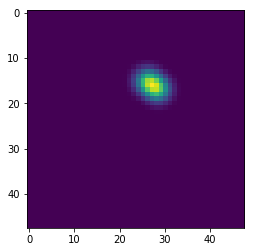

In [12]:
plt.imshow(data[RECCHANNELS].sum(axis=0))

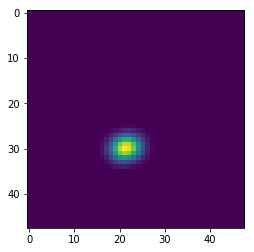

In [13]:
plt.imshow(plaindata[0].sum(axis=0))

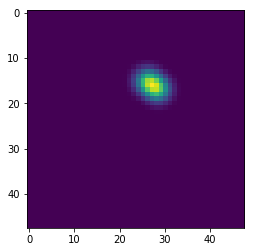

In [14]:
plt.imshow(plaindata[RECCHANNELS].sum(axis=0))

In [15]:
np.square(plaindata[0]-data[0]).sum()

2.6362384e-12

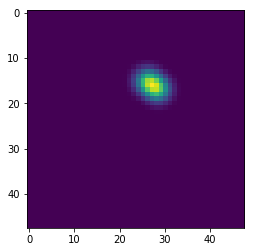

In [16]:
plt.imshow(plaindata[RECCHANNELS].sum(axis=0))

In [17]:
q.polar_decomposition

(array([ 0.28227581,  0.87702841, -0.38876925]), 0.6807621101430691)

In [18]:
import math
def toEuler(q):
    '''wikipedia, I am forever in your debt'''
    (w,x,y,z) = q.elements
    sinr_cosp = +2.0 * (w*x + y*z);
    cosr_cosp = +1.0 - 2.0 * (x*x + y*y);
    roll = math.atan2(sinr_cosp, cosr_cosp)

    # pitch (y-axis rotation)
    sinp = +2.0 * (w*y - z*x);
    if math.fabs(sinp) >= 1:
        pitch = math.copysign(math.pi / 2, sinp) # use 90 degrees if out of range
    else:
        pitch = math.asin(sinp)

    #yaw (z-axis rotation)
    siny_cosp = +2.0 * (w*z + x*y);
    cosy_cosp = +1.0 - 2.0 * (y*y + z*z);  
    yaw = math.atan2(siny_cosp, cosy_cosp);
    
    return (roll,pitch,yaw)

In [19]:
setmol(coords)
setmol(coords,'rec.xyz')
net = caffe.Net('rand.model',caffe.TEST)
res = net.forward()
data = res['data'][0].copy()

In [20]:
l =net.layers[0]
mt = l.get_moltransform(0)

In [73]:
#check peturbed ligand with rotation
center = np.mean(coords,axis=0)

setmol(coords)
setmol(coords,'rec.xyz')
net = caffe.Net('randpeturb.model',caffe.TEST)
res = net.forward()
data = res['data'][0].copy()
peturb = res['peturb'][0].copy() 
trans = peturb[:3]
q = qt(peturb[3:7])  

l =net.layers[0]
mt = l.get_moltransform(0)
Rtrans = -mt.center.x(),-mt.center.y(),-mt.center.z()
Rq = qt(mt.Q.a,mt.Q.b,mt.Q.c,mt.Q.d)

#first randomize, then peturb
newreccoords = np.array(map(Rq.rotate,coords-center))+center+Rtrans
newligcoords = np.array(map(Rq.rotate,coords-center))+center+Rtrans
center = np.mean(newligcoords,axis=0)
print newligcoords,center
newligcoords = np.array(map(q.inverse.rotate,newligcoords-center))+center-trans

setmol(newligcoords)
setmol(newreccoords,'rec.xyz')
plainnet = caffe.Net('plain.model',caffe.TEST)
plainres = plainnet.forward()
plaindata = plainres['data'][0].copy()

diff = np.square(plaindata - data).sum()
diff

[[-1.75233643  1.83239021  5.0804288 ]
 [-0.62854947  2.27988449  4.17323767]] [-1.19044295  2.05613735  4.62683324]


6.121551e-11

In [72]:
coords,trans

(array([[1.061, 0.053, 0.063],
        [2.573, 0.053, 0.063]]),
 array([ 1.2968907, -2.8041916,  2.785613 ], dtype=float32))

In [69]:
newreccoords,newligcoords

(array([[ 0.02988771, -1.44820632,  2.92229312],
        [ 1.26441827, -0.8007472 ,  3.5078484 ]]),
 array([[0.26899037, 1.80435657, 2.98428213],
        [0.88352438, 1.72847491, 4.36367835]]))

In [70]:
Rtrans,center

((-1.169847011566162, -1.1774767637252808, 3.1520707607269287),
 array([ 0.64715299, -1.12447676,  3.21507076]))

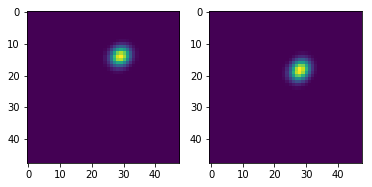

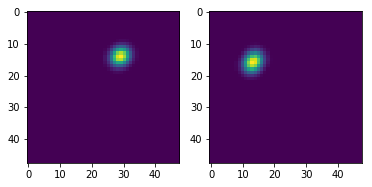

In [64]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(data[0].sum(axis=0))
ax2.imshow(data[RECCHANNELS].sum(axis=0))
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(plaindata[0].sum(axis=0))
ax2.imshow(plaindata[RECCHANNELS].sum(axis=0))

In [21]:
trans = -mt.center.x(),-mt.center.y(),-mt.center.z()
q = qt(mt.Q.a,mt.Q.b,mt.Q.c,mt.Q.d)
trans,q

((3.1082372665405273, -1.0867971181869507, 3.8376243114471436),
 Quaternion(0.7312277555465698, -0.4317969083786011, 0.2525993585586548, 0.4637358486652374))

In [22]:
newcoords = np.array(map(q.rotate,coords))+trans


In [23]:
newcoords

array([[ 3.52803904, -0.53370017,  3.03118198],
       [ 4.19677432,  0.16189515,  1.86710111]])

In [24]:
setmol(newcoords)
setmol(newcoords,'rec.xyz')
plainnet = caffe.Net('plain.model',caffe.TEST)
plainres = plainnet.forward()
plaindata = plainres['data'][0].copy()

diff = np.square(plaindata - data).sum()

In [25]:
np.square(plaindata[RECCHANNELS]-data[RECCHANNELS]).sum(),np.square(plaindata[0]-data[0]).sum()

(147.8159, 147.8159)

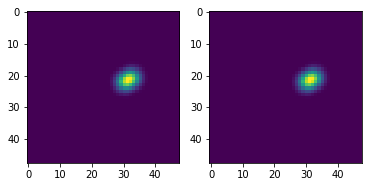

In [26]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(data[0].sum(axis=0))
ax2.imshow(data[RECCHANNELS].sum(axis=0))


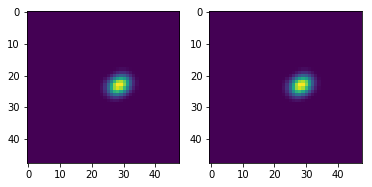

In [27]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(plaindata[0].sum(axis=0))
ax2.imshow(plaindata[RECCHANNELS].sum(axis=0))


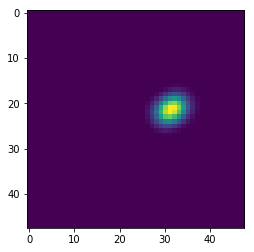

In [28]:
plt.imshow(data[RECCHANNELS].sum(axis=0))


In [29]:
setmol(coords)
setmol(coords,'rec.xyz')
net = caffe.Net('fullrandpeturb.model',caffe.TEST)
res = net.forward()
data = res['data'][0].copy()
peturb = res['peturb'][0].copy() 
trans = peturb[:3]
q = qt(peturb[3:7])  

l =net.layers[0]
mt = l.get_moltransform(0)
Rtrans = -mt.center.x(),-mt.center.y(),-mt.center.z()
Rq = qt(mt.Q.a,mt.Q.b,mt.Q.c,mt.Q.d)

center = np.mean(coords,axis=0)

In [30]:
Rtrans,center

((0.854245662689209, 1.9951069355010986, 1.4428610801696777),
 array([1.817, 0.053, 0.063]))

In [31]:
coords

array([[1.061, 0.053, 0.063],
       [2.573, 0.053, 0.063]])

In [32]:
newreccoords = np.array(map(Rq.rotate,coords-center))+center+Rtrans
newreccoords

array([[1.99501475, 2.03423696, 1.16814023],
       [3.34747658, 2.06197691, 1.84358193]])

In [33]:
np.mean(coords,axis=0)

array([1.817, 0.053, 0.063])

In [74]:
setmol(coords)
setmol(coords,'rec.xyz')
net = caffe.Net('fullrandpeturb.model',caffe.TEST)
res = net.forward()
data = res['data'][0].copy()
peturb = res['peturb'][0].copy() 
trans = peturb[:3]
q = qt(peturb[3:7])  

l =net.layers[0]
mt = l.get_moltransform(0)
Rtrans = -mt.center.x(),-mt.center.y(),-mt.center.z()
Rq = qt(mt.Q.a,mt.Q.b,mt.Q.c,mt.Q.d)

center = np.mean(coords,axis=0)

#first rotate
newligcoords = np.array(map(Rq.rotate,coords-center))+center+Rtrans
newreccoords = np.array(map(Rq.rotate,coords-center))+center+Rtrans
center = np.mean(newligcoords,axis=0)
#then peturb, using updated ligand center
newligcoords = np.array(map(q.inverse.rotate,newligcoords-center))+center-trans

setmol(newligcoords)
setmol(newreccoords,'rec.xyz')
plainnet = caffe.Net('plain.model',caffe.TEST)
plainres = plainnet.forward()
plaindata = plainres['data'][0].copy()

diff = np.square(plaindata - data).sum()
diff,np.square(plaindata[0]-data[0]).sum()

(3.0790936e-11, 2.0944232e-11)

In [35]:
Rtrans,np.mean(newligcoords,axis=0),peturb

((-0.8328893780708313, -4.699767112731934, 1.7686649560928345),
 array([-1.10955331, -2.88140247,  4.26684061]),
 array([-2.093664  ,  1.7653646 ,  2.4351757 , -0.5831116 , -0.31520006,
        -0.16427855,  0.7305082 ,  0.16908593,  0.71034837, -1.7314305 ],
       dtype=float32))

In [36]:
Rtrans

(-0.8328893780708313, -4.699767112731934, 1.7686649560928345)

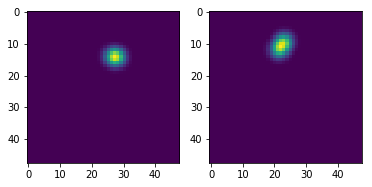

In [37]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(data[0].sum(axis=0))
ax2.imshow(data[RECCHANNELS].sum(axis=0))

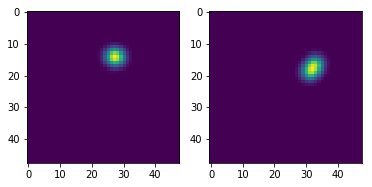

In [38]:
f, (ax1,ax2) = plt.subplots(1,2)
ax1.imshow(plaindata[0].sum(axis=0))
ax2.imshow(plaindata[RECCHANNELS].sum(axis=0))


In [39]:
np.square(plaindata[0]-data[0]).sum()

1.750977e-11

In [40]:
newreccoords

array([[ 0.32588257, -4.57999158,  2.19746937],
       [ 1.64233867, -4.71354264,  1.46586055]])